## DEX US EU

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random_walk_model import (
    discretise_Wt,
    simulate_multiple_discrete_paths,
    forecast_from_multiple_paths,
    plot_multiple_paths_vs_history
)
from arima_model import (
    forecast_and_plot_arima,
    evaluate_forecast_metrics
)



# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()


,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-05,1.1918,1.1918,0.175465,-0.008106,-0.008049
2015-01-06,1.1936,1.1936,0.176974,0.001509,0.001566
2015-01-07,1.1820,1.1820,0.167208,-0.009766,-0.009709
2015-01-08,1.1811,1.1811,0.166446,-0.000762,-0.000705
2015-01-09,1.1830,1.1830,0.168054,0.001607,0.001665


### Random Walk

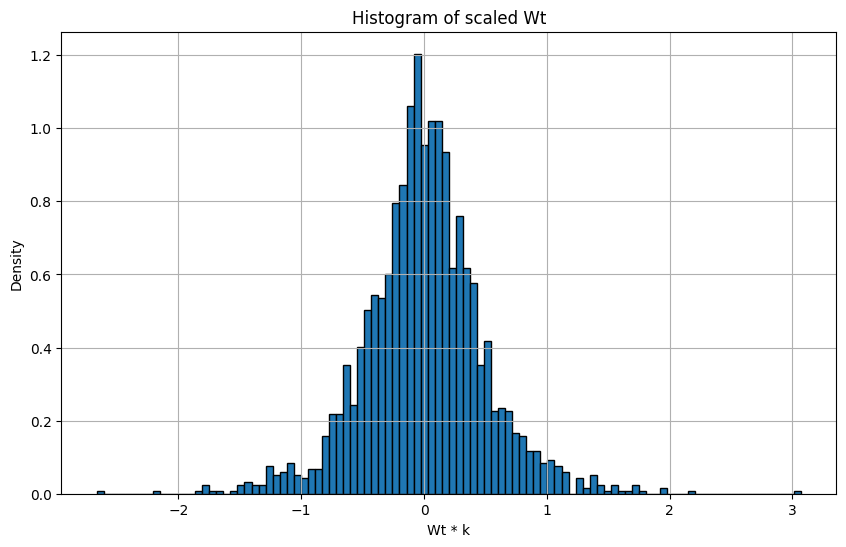

count    2085.000000
mean        0.000001
std         0.004929
min        -0.026667
25%        -0.002622
50%        -0.000034
75%         0.002716
max         0.030700
Name: Wt, dtype: float64


In [68]:
k = 100
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1247, P(0) = 0.7535, P(+1) = 0.1218


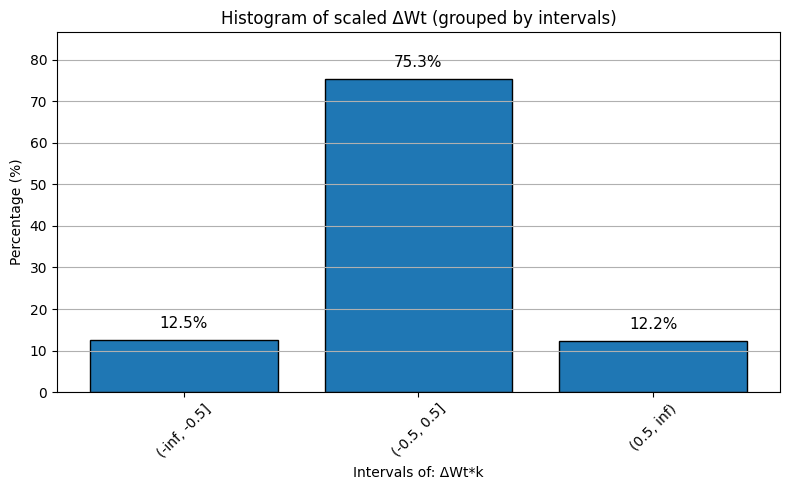

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-05,1.1918,1.19180,0.175465,-0.008106,-0.008049,-0.804883,-1,"(-inf, -0.5]"
2015-01-06,1.1936,1.19360,0.176974,0.001509,0.001566,0.156636,0,"(-0.5, 0.5]"
2015-01-07,1.1820,1.18200,0.167208,-0.009766,-0.009709,-0.970885,-1,"(-inf, -0.5]"
2015-01-08,1.1811,1.18110,0.166446,-0.000762,-0.000705,-0.070453,0,"(-0.5, 0.5]"
2015-01-09,1.1830,1.18300,0.168054,0.001607,0.001665,0.166456,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-26,NaN,1.06375,0.061800,0.001552,0.001610,0.160950,0,"(-0.5, 0.5]"
2022-12-27,1.0654,1.06540,0.063350,0.001550,0.001607,0.160710,0,"(-0.5, 0.5]"
2022-12-28,1.0622,1.06220,0.060342,-0.003008,-0.002951,-0.295090,0,"(-0.5, 0.5]"


In [69]:
# ----------------------------------------
# with DEXUSEU training data
# ----------------------------------------

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)
# Step 1: Discretise Wt and get probabilities
k=100
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu


In [70]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.13, 0: 0.74, 1: 0.13}

# trend estimation (preproccessing)
estimated_mu = -0.000004  # this must be your actual drift!
estimated_mu = -0.000057

# df for testing
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

In [71]:
# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=366*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Export df_forecast for DEXUSEU to CSV
df_paths.index.name = 'path_number'
df_paths.to_csv('df_forecast_dexuseu.csv')

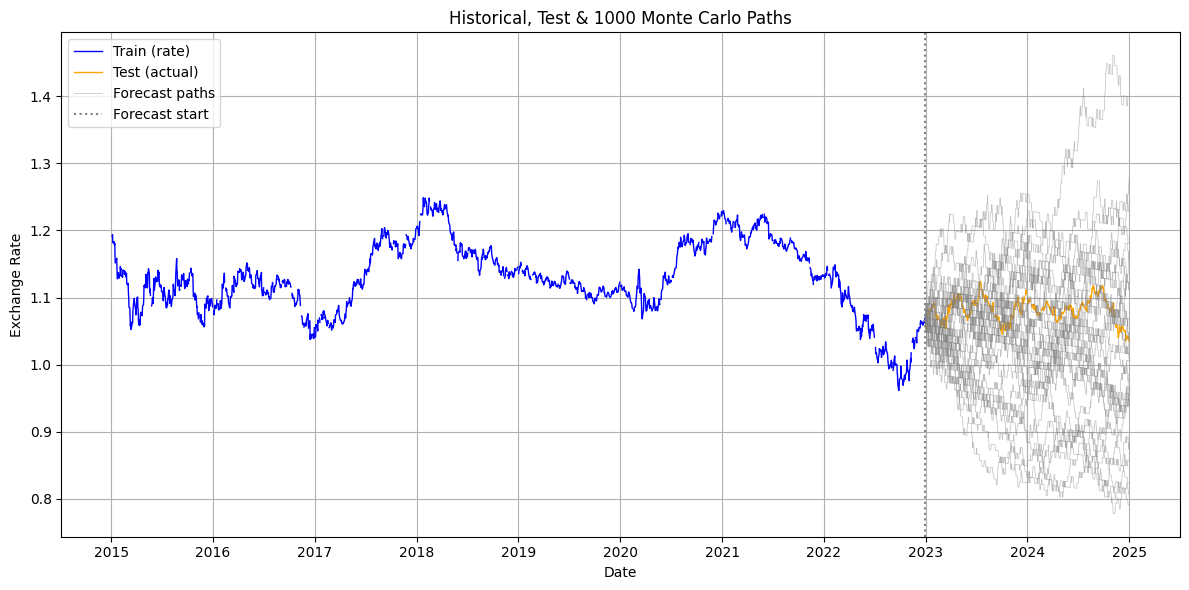

In [72]:
# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

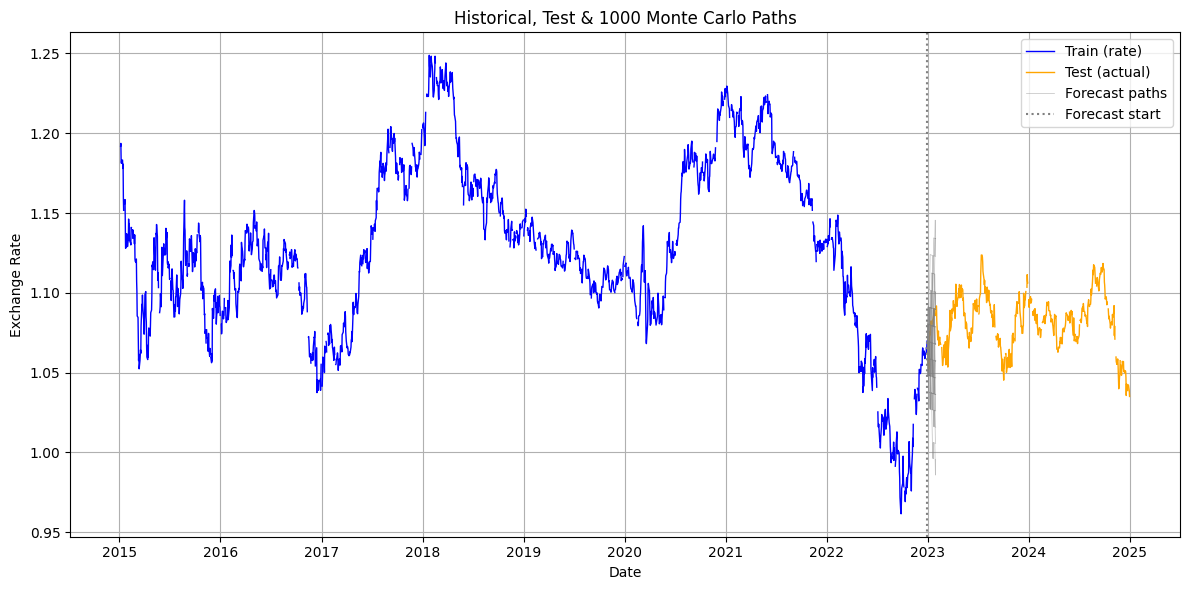

In [73]:
# RW for 1 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=31,      # simulate 1 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Export df_forecast for DEXUSEU to CSV
df_paths.index.name = 'path_number'
df_paths.to_csv('df_forecast_dexuseu_1_month.csv')

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

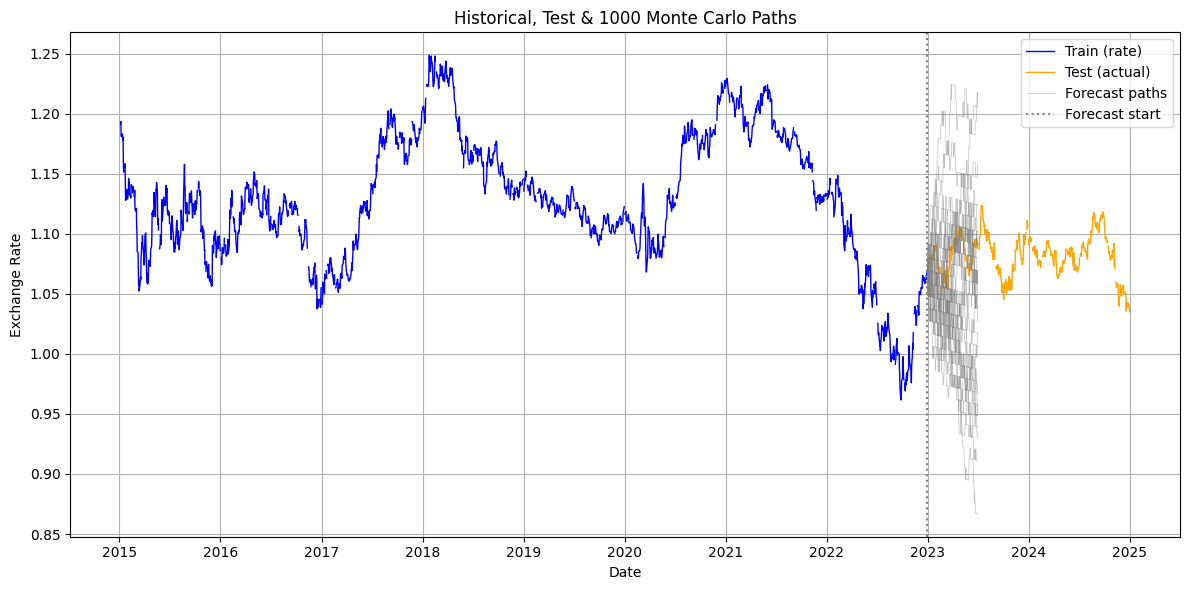

In [74]:
# RW for 6 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon= 182,      # simulate 6 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Export df_forecast for DEXUSEU to CSV
df_paths.index.name = 'path_number'
df_paths.to_csv('df_forecast_dexuseu_6_month.csv')

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

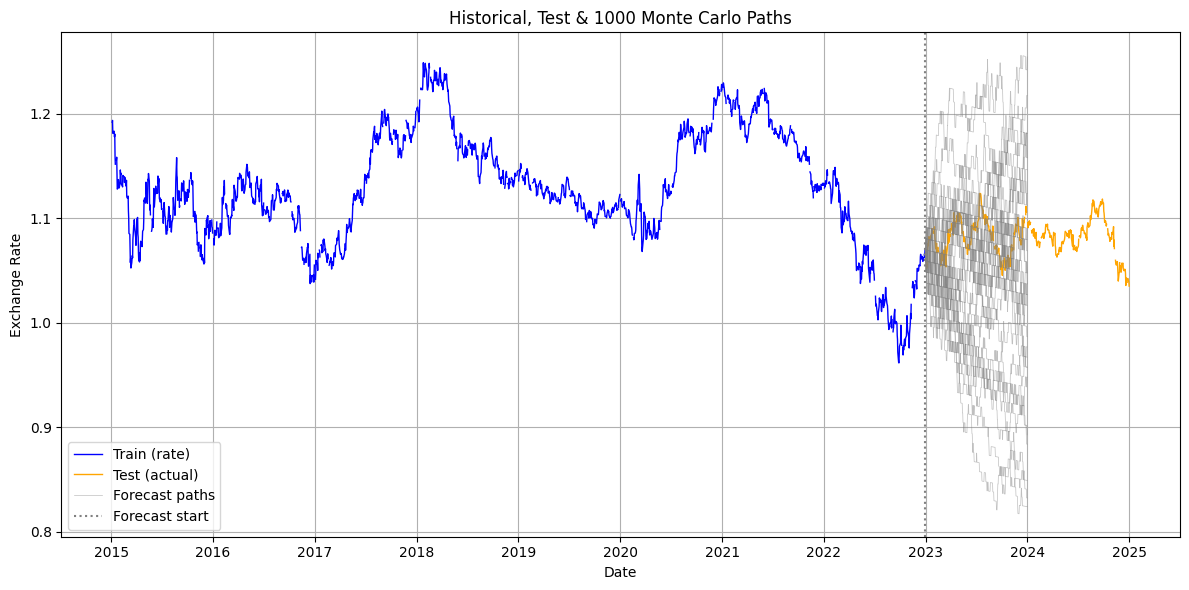

In [75]:
# RW for 12 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=366,      # simulate 6 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Export df_forecast for DEXUSEU to CSV
df_paths.index.name = 'path_number'
df_paths.to_csv('df_forecast_dexuseu_12_month.csv')

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

### ARIMA model

In [76]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# train_df is already loaded with index as date
series = train_df['log_rate'] # or diff? or Wt?


In [77]:
# DETERMINE d (differencing order) using ADF and KPSS tests
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# with pmdarima helper:
d_adf = ndiffs(train_df['log_rate'], test='adf')
# d_kpss = ndiffs(train_df['log_rate'], test='kpss')
print("Recommended d (ADF):", d_adf)
# print("Recommended d (KPSS):", d_kpss)

# Direct ADF test  Augmented Dickey-Fuller already done in preprocessing
adf_res = adfuller(train_df['log_rate'])
print("ADF p-value:", adf_res[1])

Recommended d (ADF): 1
ADF p-value: 0.12271024894831561


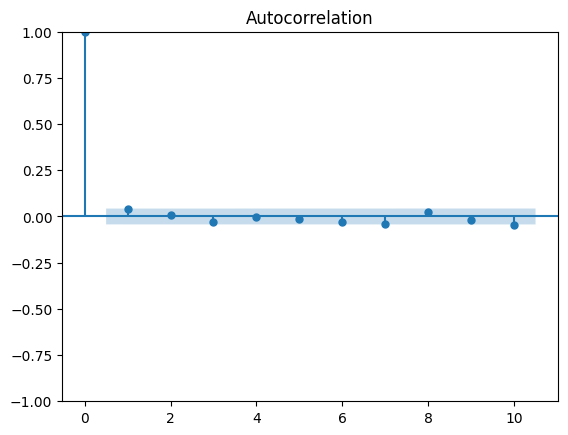

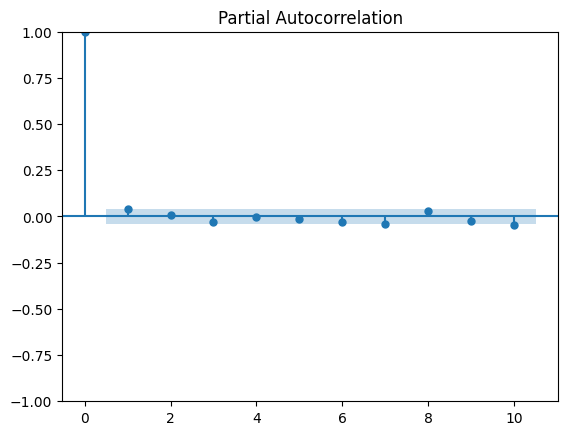

In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# diff_series = train_df['log_rate'].diff().dropna()
diff_series = train_df['Wt'].dropna()

# selct q: with ACF autocorrelation function
plot_acf(diff_series, lags=10)
plt.show()

# for select p with PACF partial autocorrelation function
plot_pacf(diff_series, lags=10)
plt.show()

In [79]:
# Using auto arima to selct p and q
import pmdarima as pm

auto_model = pm.auto_arima(train_df['log_rate'],
                           start_p=0, max_p=5,
                           start_q=0, max_q=5,
                           d=1, seasonal=False, trace=True,
                           error_action='ignore', suppress_warnings=True)

print(auto_model.summary())
p, d, q = auto_model.order
print(f"Best order: p={p}, d={d}, q={q}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16227.269, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16229.198, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16229.144, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16229.038, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16227.233, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16227.212, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16221.266, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16230.987, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16229.026, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16229.003, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16230.934, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16227.024, Time=0.45 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.170 seconds
                               SARIMAX Results                  

In [80]:
# Interpretation:

# ar.L1 (coef = 0.0321): a small positive AR(1) effect.
# std err (0.018): standard error of the coefficient.
# z = 1.740 and P>|z| = 0.082: the test statistic and p-value for H0: coefficient = 0. 
# Since p = 0.082 > 0.05, ar.L1 is not statistically significant at 5% (there’s ~8.2% chance the coefficient is zero).


# [0.975 & 0.025]: 95 % confidence interval for each parameter:
# For ar.L1: from –0.004 to 0.068 → interval crosses zero → not significant.
# For sigma2: its narrow interval (2.49e‑05 – 2.72e‑05) is always > 0 → noise variance significantly non-zero.

In [81]:
# Ljung‑Box (L1) Q = 0.00, Prob(Q) = 0.99
# — Tests autocorrelation of residuals. High p‑value (0.99) → cannot reject null → residuals behave like white noise.

# Jarque–Bera (JB) = 413.49, Prob(JB) = 0.00
# — Tests normality. p‑value 0 → residuals are not normally distributed (non-normality indicated).

# Heteroskedasticity (H) = 0.59, Prob(H) = 0.00
# — Tests constant variance. p‑value 0 → residuals have non-constant variance (heteroskedastic).

# Skew = 0.04, Kurtosis = 5.23
# — Slightly heavier tails (kurtosis > 3), mild asymmetry.

In [82]:
# Fit the final ARIMA model
model = ARIMA(train_df['log_rate'], order=(1,1,0))
res = model.fit()


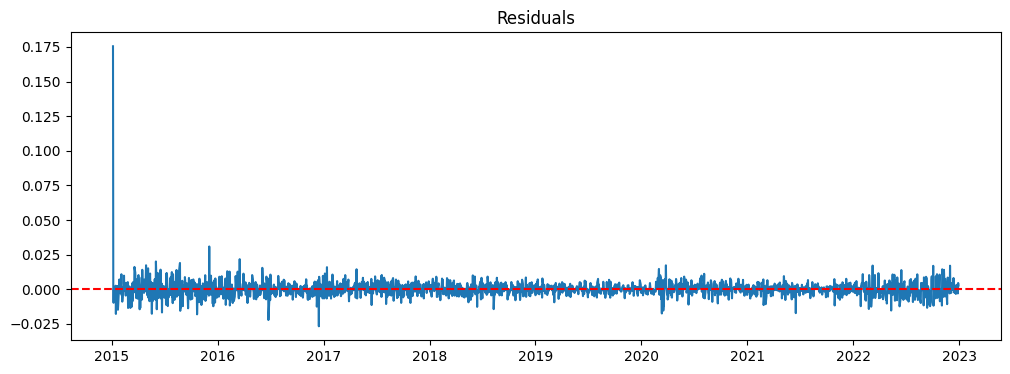

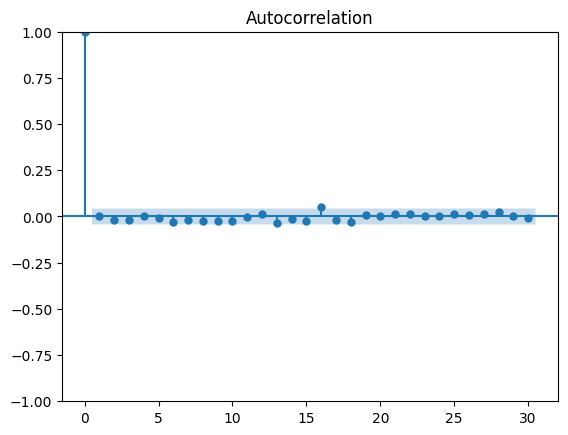

      lb_stat  lb_pvalue
10   7.682306   0.659837
20  21.109589   0.390708


In [83]:
# Residual Diagnostics
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = res.resid

# Residual plot
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals')
plt.show()

# ACF of residuals
plot_acf(resid, lags=30)
plt.show()

# Ljung-Box test: high p-values (>0.05) => residuals are white noise
print(acorr_ljungbox(resid, lags=[10,20], return_df=True))

# Goal: Residuals should look like white noise: no autocorrelation, constant variance, mean ~0.


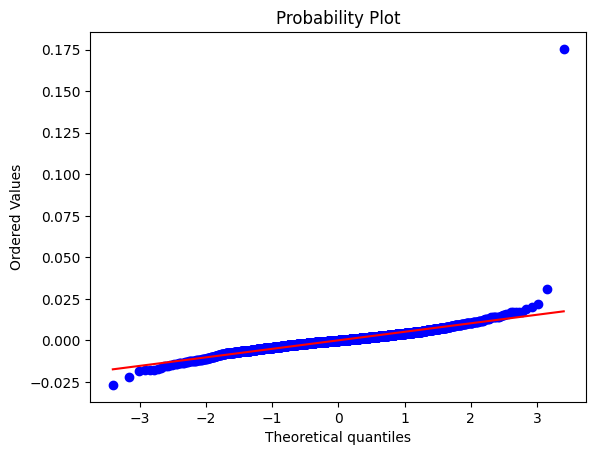

In [84]:
# checking normality of residuals
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(resid.dropna(), dist="norm", plot=plt)
plt.show()


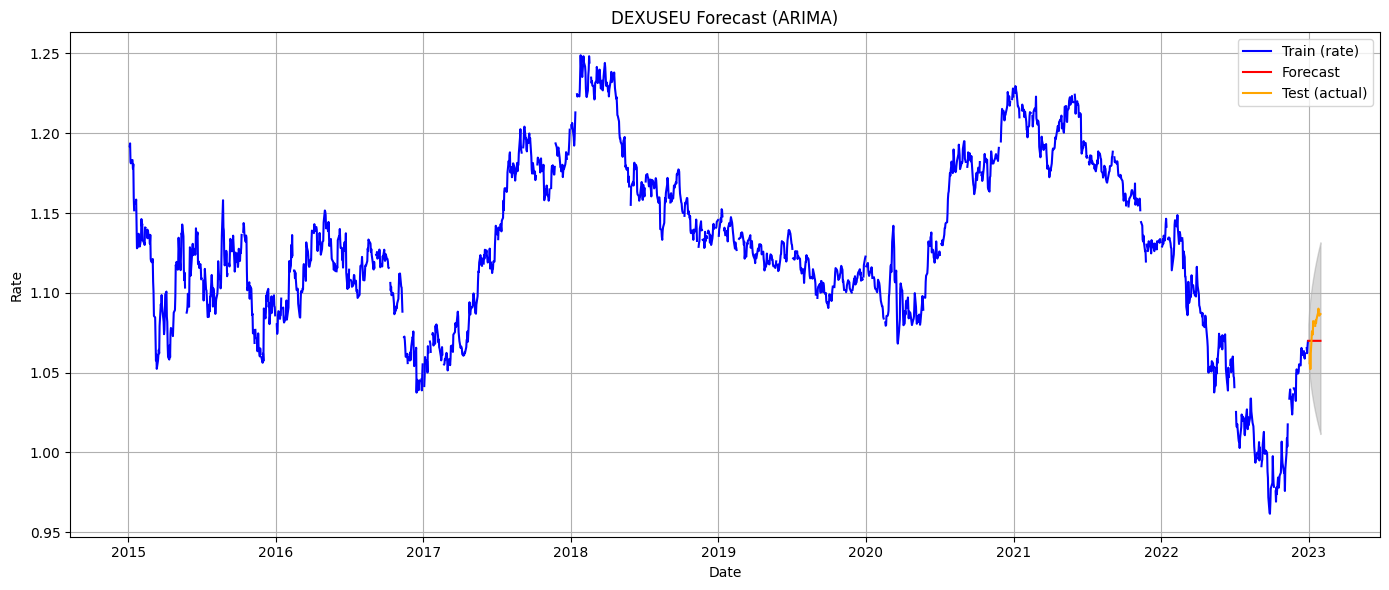

Aligned y_true: 19, y_pred: 19
✅ RMSE: 0.013216
✅ MAE: 0.012352


In [85]:
# forecast and plot arima: 1 month ahead

# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

fc_rate, test_rate = forecast_and_plot_arima(
    res=res,                # fitted ARIMA model
    train_df=train_df,      # your training data
    test_df=test_df,        # your test data
    steps=31,              # forecast horizon
    rate_col='rate',        # column with actual exchange rate
    title='DEXUSEU Forecast (ARIMA)'
)
metrics = evaluate_forecast_metrics(fc_rate, test_df, rate_col='rate')

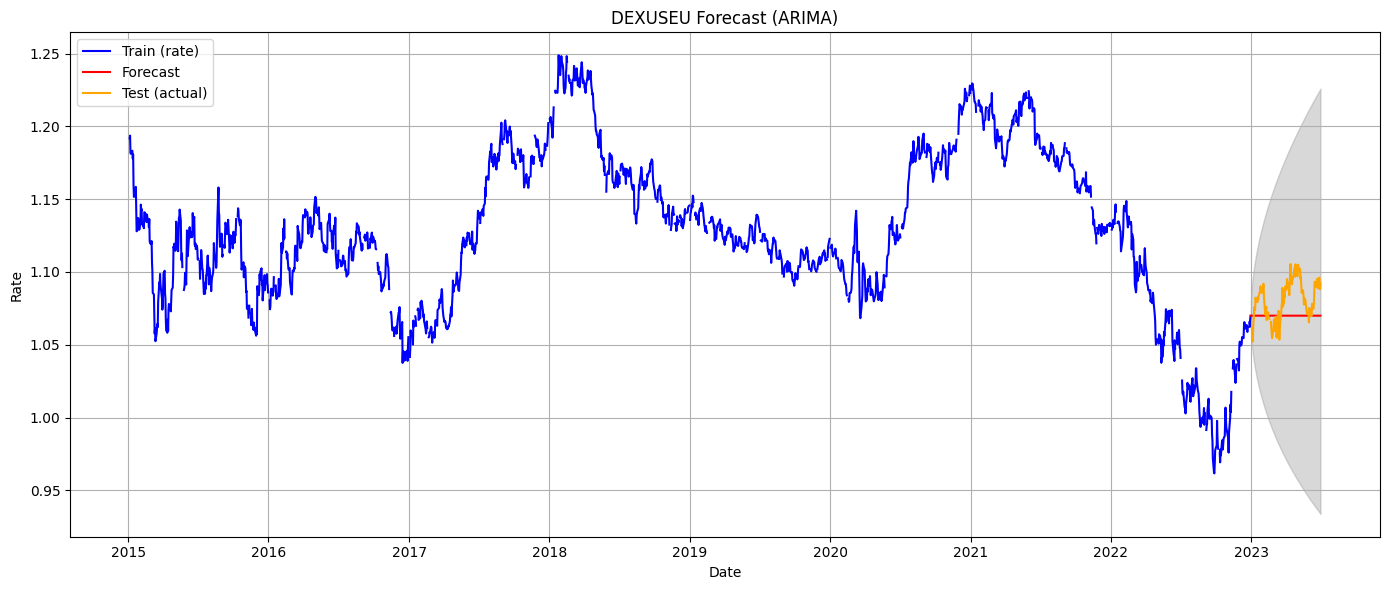

Aligned y_true: 125, y_pred: 125
✅ RMSE: 0.017372
✅ MAE: 0.014470


In [86]:
# forecast and plot arima: 6 month ahead

# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

fc_rate, test_rate = forecast_and_plot_arima(
    res=res,                # fitted ARIMA model
    train_df=train_df,      # your training data
    test_df=test_df,        # your test data
    steps=182,              # forecast horizon
    rate_col='rate',        # column with actual exchange rate
    title='DEXUSEU Forecast (ARIMA)'
)
metrics = evaluate_forecast_metrics(fc_rate, test_df, rate_col='rate')

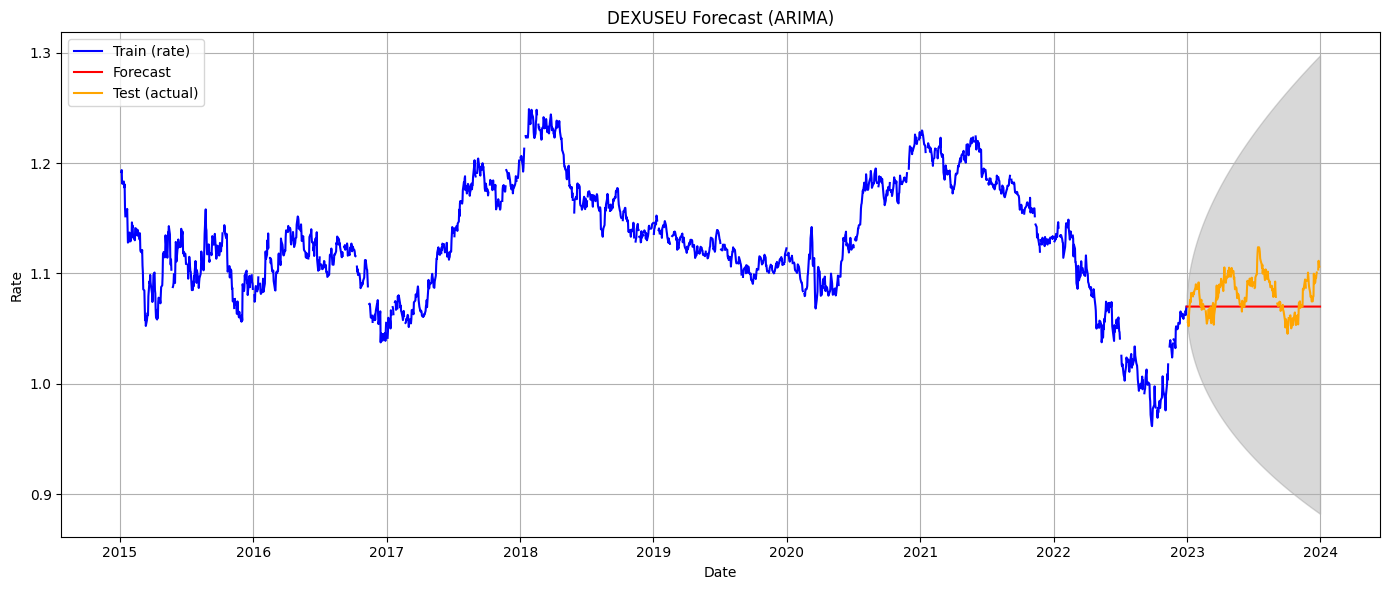

Aligned y_true: 249, y_pred: 249
✅ RMSE: 0.020184
✅ MAE: 0.016591


In [87]:
# forecast and plot arima: 12 month ahead

# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

fc_rate, test_rate = forecast_and_plot_arima(
    res=res,                # fitted ARIMA model
    train_df=train_df,      # your training data
    test_df=test_df,        # your test data
    steps=366,              # forecast horizon
    rate_col='rate',        # column with actual exchange rate
    title='DEXUSEU Forecast (ARIMA)'
)
metrics = evaluate_forecast_metrics(fc_rate, test_df, rate_col='rate')

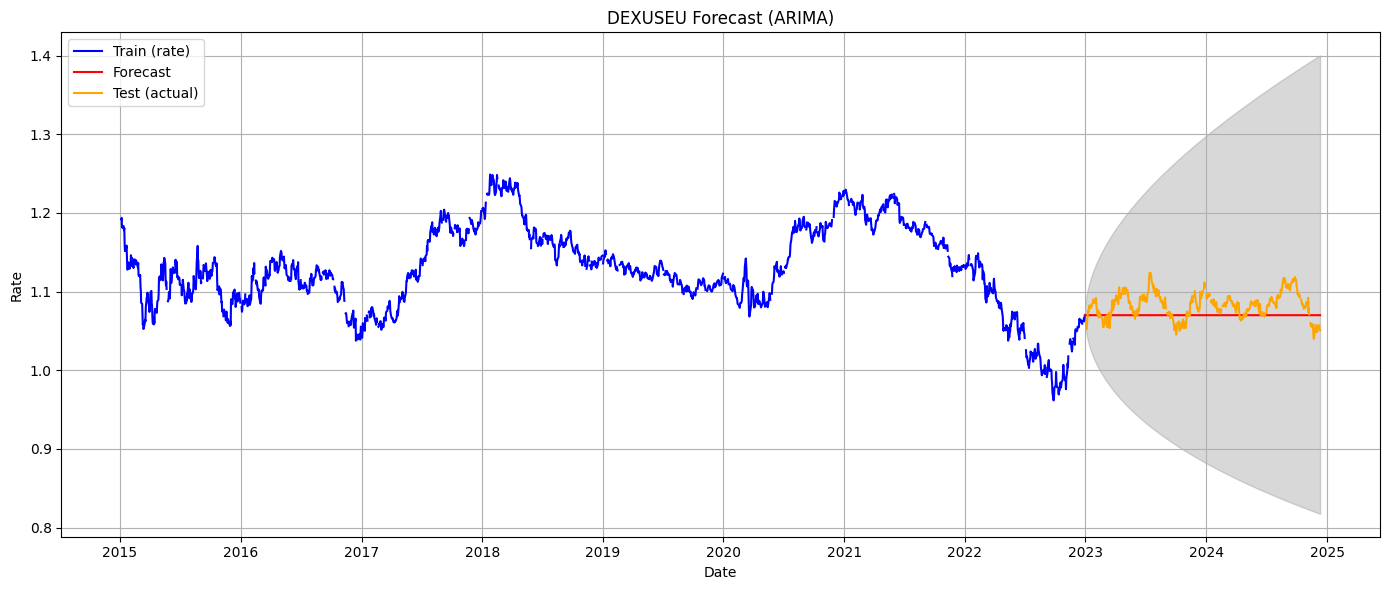

Aligned y_true: 487, y_pred: 487
✅ RMSE: 0.020594
✅ MAE: 0.017032


In [62]:
# forecast and plot arima: 2 years ahead

# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

fc_rate, test_rate = forecast_and_plot_arima(
    res=res,                # fitted ARIMA model
    train_df=train_df,      # your training data
    test_df=test_df,        # your test data
    steps=366*2,              # forecast horizon
    rate_col='rate',        # column with actual exchange rate
    title='DEXUSEU Forecast (ARIMA)'
)
metrics = evaluate_forecast_metrics(fc_rate, test_df, rate_col='rate')


In [ ]:
# lower than RW, ARIMA is better than RW for 1 month, 6 , 12, 24 month ahead forecasts

## DEX US SF

In [142]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexussf.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-06,0.085466,0.085466,-2.459632,0.001281,0.001404
2015-01-07,0.085415,0.085415,-2.460230,-0.000598,-0.000475
2015-01-08,0.086558,0.086558,-2.446945,0.013285,0.013408
2015-01-09,0.087070,0.087070,-2.441042,0.005903,0.006026
2015-01-12,0.086760,0.086760,-2.444605,-0.003564,-0.003440


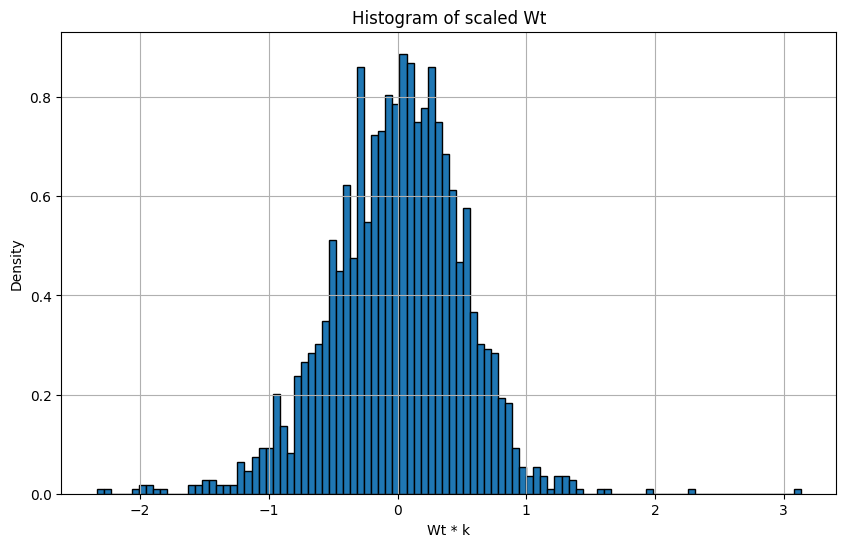

count    1996.000000
mean       -0.000063
std         0.010218
min        -0.046778
25%        -0.006204
50%         0.000465
75%         0.006662
max         0.062697
Name: Wt, dtype: float64


In [143]:
k = 50
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1518, P(0) = 0.6999, P(+1) = 0.1483


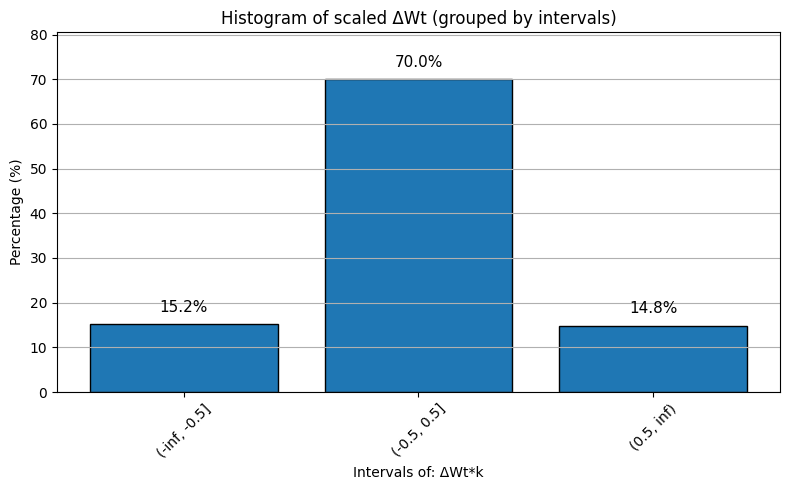

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-06,0.085466,0.085466,-2.459632,0.001281,0.001404,0.070212,0,"(-0.5, 0.5]"
2015-01-07,0.085415,0.085415,-2.460230,-0.000598,-0.000475,-0.023751,0,"(-0.5, 0.5]"
2015-01-08,0.086558,0.086558,-2.446945,0.013285,0.013408,0.670379,1,"(0.5, inf)"
2015-01-09,0.087070,0.087070,-2.441042,0.005903,0.006026,0.301319,0,"(-0.5, 0.5]"
2015-01-12,0.086760,0.086760,-2.444605,-0.003564,-0.003440,-0.172023,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-23,0.058919,0.058919,-2.831594,0.009966,0.010089,0.504472,1,"(0.5, inf)"
2022-12-27,0.057793,0.057793,-2.850880,-0.019286,-0.019162,-0.958122,-1,"(-inf, -0.5]"
2022-12-28,0.058428,0.058428,-2.839955,0.010925,0.011048,0.552384,1,"(0.5, inf)"


In [144]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

In [145]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.15, 0: 0.7, 1: 0.15}

# Step 2: Simulate one 2-year path
path = simulate_one_discrete_path(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,  # 2 years ≈ 504 trading days
    seed=24
)
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)

In [146]:
# Assume:
# - path is your simulated scaled_Wt
# - k = 50
# - mu was estimated via linear regression on log_rate -0.000123
estimated_mu = -0.000123  # this must be your actual drift!

df_forecast_summary = forecast_from_multiple_paths(
    train_df=train_df_dexuseu,
    paths=paths,
    k=k,
    mu=estimated_mu
)

df_forecast = forecast_exchange_rate_from_simulation(
    train_df=train_df_dexuseu,
    simulated_path=path,
    k=k,
    mu=estimated_mu # this must be your actual drift!
)


In [147]:
df_forecast_summary

,log_rate_mean,log_rate_lower,log_rate_upper,rate_mean,rate_lower,rate_upper
2022-12-31,-2.832482,-2.853042,-2.813042,0.058870,0.057669,0.060022
2023-01-01,-2.833065,-2.853165,-2.793165,0.058839,0.057662,0.061227
2023-01-02,-2.833428,-2.873288,-2.793288,0.058822,0.056513,0.061220
2023-01-03,-2.833631,-2.873411,-2.793411,0.058813,0.056506,0.061212
2023-01-04,-2.834034,-2.873534,-2.793534,0.058793,0.056499,0.061205
...,...,...,...,...,...,...
2024-12-25,-2.924717,-3.502217,-2.362217,0.056073,0.030131,0.094211
2024-12-26,-2.924900,-3.502340,-2.362340,0.056071,0.030127,0.094200
2024-12-27,-2.925123,-3.502463,-2.362463,0.056054,0.030123,0.094188
2024-12-28,-2.925326,-3.502586,-2.362586,0.056040,0.030119,0.094176


In [148]:
# Export df_forecast for DEXUSEU to CSV
df_forecast_summary.index.name = 'date'
df_forecast_summary.to_csv('df_forecast_dexussf.csv')

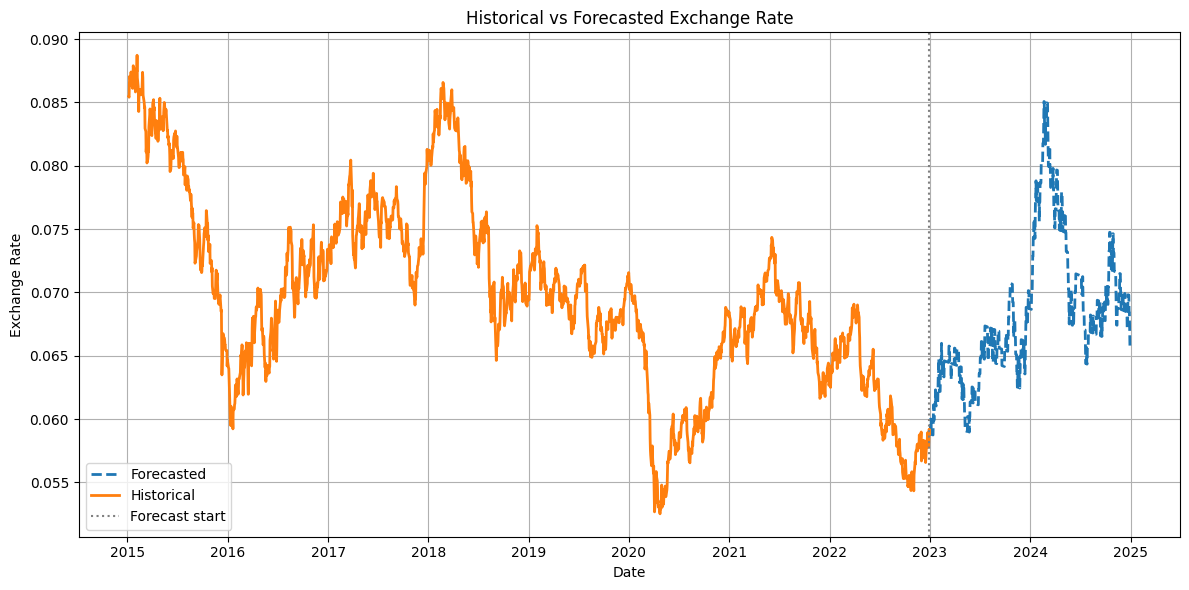

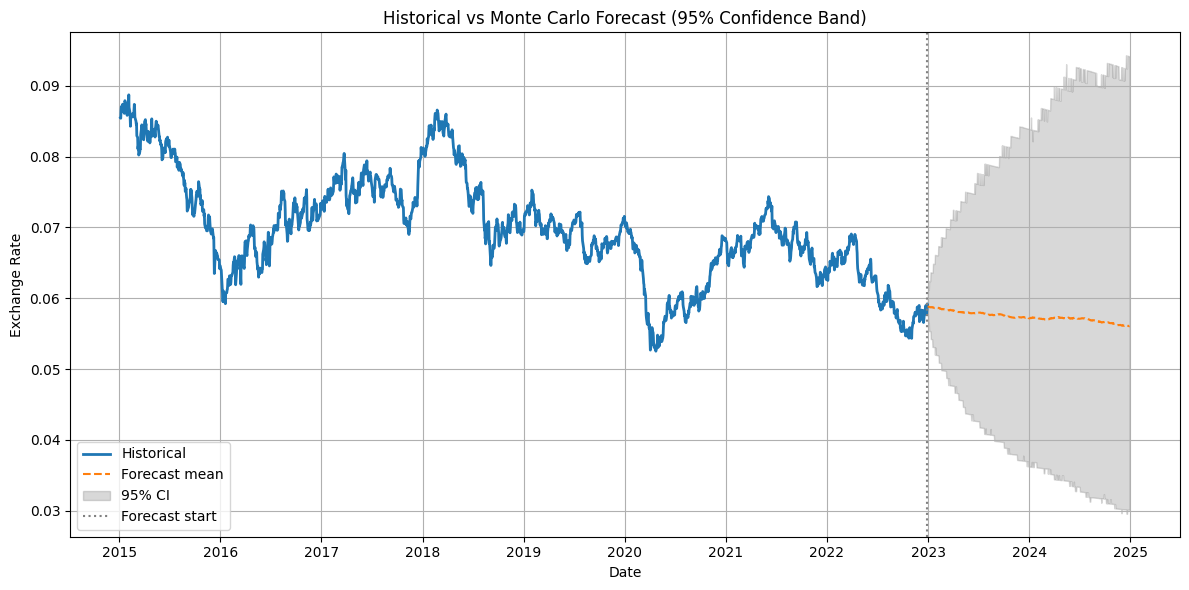

In [149]:
combined_df = plot_forecast_vs_history(train_df_dexuseu, df_forecast, rate_col='rate', rate_pred_col='rate_pred')
combined_df = plot_forecast_summary_vs_history(train_df_dexuseu, df_forecast_summary)


In [150]:
combined_df

,rate,source
date,,
2015-01-06,0.085466,Historical
2015-01-07,0.085415,Historical
2015-01-08,0.086558,Historical
2015-01-09,0.087070,Historical
2015-01-12,0.086760,Historical
...,...,...
2024-12-25,0.056073,Forecasted
2024-12-26,0.056071,Forecasted
2024-12-27,0.056054,Forecasted


## DEX US PEN

In [151]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_usdpen.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-07,0.334784,0.334784,-1.094270,-0.001340,-0.001232
2015-01-08,0.334560,0.334560,-1.094939,-0.000669,-0.000562
2015-01-09,0.334896,0.334896,-1.093935,0.001004,0.001112
2015-01-12,0.334560,0.334560,-1.094939,-0.001004,-0.000896
2015-01-13,0.335008,0.335008,-1.093600,0.001339,0.001447


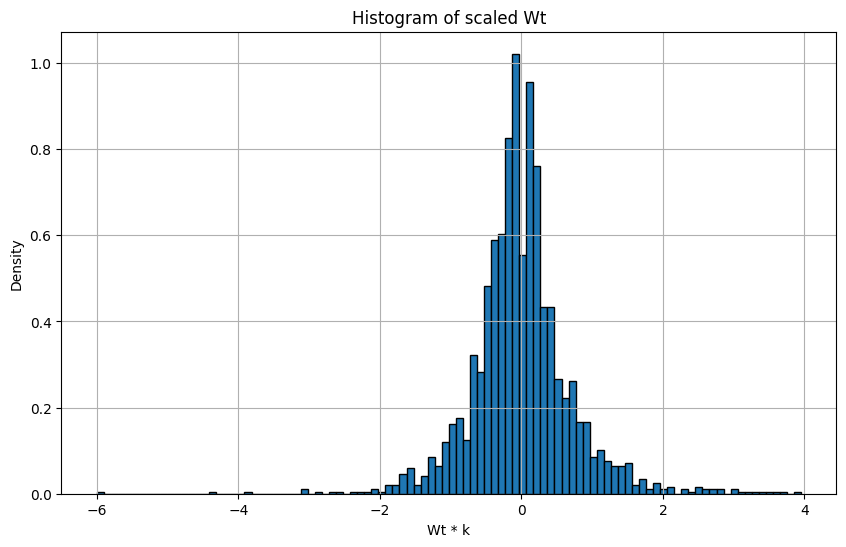

count    1996.000000
mean       -0.000016
std         0.003623
min        -0.030015
25%        -0.001727
50%        -0.000188
75%         0.001528
max         0.019757
Name: Wt, dtype: float64


In [152]:
k = 200
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1759, P(0) = 0.6603, P(+1) = 0.1638


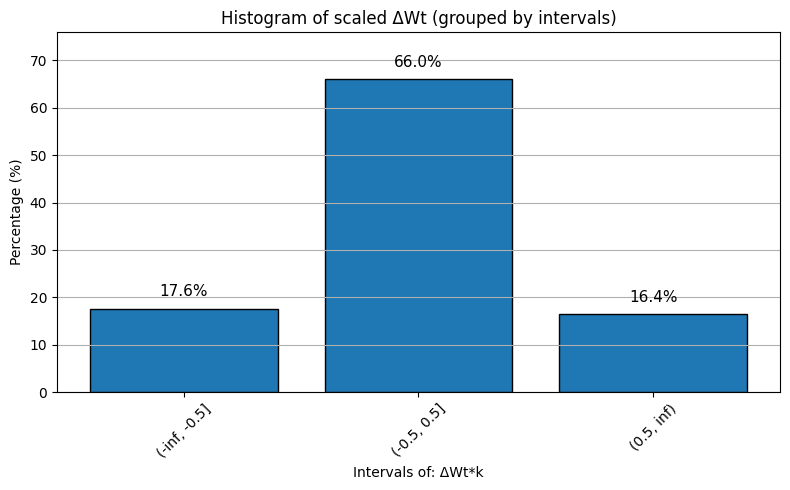

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-07,0.334784,0.334784,-1.094270,-0.001340,-0.001232,-0.246452,0,"(-0.5, 0.5]"
2015-01-08,0.334560,0.334560,-1.094939,-0.000669,-0.000562,-0.112314,0,"(-0.5, 0.5]"
2015-01-09,0.334896,0.334896,-1.093935,0.001004,0.001112,0.222392,0,"(-0.5, 0.5]"
2015-01-12,0.334560,0.334560,-1.094939,-0.001004,-0.000896,-0.179282,0,"(-0.5, 0.5]"
2015-01-13,0.335008,0.335008,-1.093600,0.001339,0.001447,0.289382,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-26,0.261575,0.261575,-1.341035,0.001046,0.001154,0.230705,0,"(-0.5, 0.5]"
2022-12-27,0.261643,0.261643,-1.340774,0.000262,0.000369,0.073877,0,"(-0.5, 0.5]"
2022-12-28,0.261986,0.261986,-1.339465,0.001309,0.001417,0.283369,0,"(-0.5, 0.5]"


In [153]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

In [154]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.17, 0: 0.66, 1: 0.17}

# Step 2: Simulate one 2-year path
path = simulate_one_discrete_path(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,  # 2 years ≈ 504 trading days
    seed=24
)
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)

In [155]:
# Assume:
# - path is your simulated scaled_Wt
# - k = 50
# - mu was estimated via linear regression on log_rate -0.000123
estimated_mu = -0.000123  # this must be your actual drift!

df_forecast_summary = forecast_from_multiple_paths(
    train_df=train_df_dexuseu,
    paths=paths,
    k=k,
    mu=estimated_mu
)

df_forecast = forecast_exchange_rate_from_simulation(
    train_df=train_df_dexuseu,
    simulated_path=path,
    k=k,
    mu=estimated_mu # this must be your actual drift!
)

In [156]:
df_forecast_summary

,log_rate_mean,log_rate_lower,log_rate_upper,rate_mean,rate_lower,rate_upper
2022-12-31,-1.340223,-1.345373,-1.335373,0.261788,0.260442,0.263060
2023-01-01,-1.340446,-1.350496,-1.330496,0.261731,0.259112,0.264346
2023-01-02,-1.340609,-1.350619,-1.330619,0.261690,0.259080,0.264313
2023-01-03,-1.340727,-1.350742,-1.330742,0.261660,0.259048,0.264281
2023-01-04,-1.340975,-1.355865,-1.330865,0.261596,0.257724,0.264248
...,...,...,...,...,...,...
2024-12-25,-1.430073,-1.584673,-1.284548,0.240037,0.205015,0.276776
2024-12-26,-1.430256,-1.584671,-1.284671,0.239995,0.205015,0.276741
2024-12-27,-1.430364,-1.589794,-1.284794,0.239969,0.203968,0.276707
2024-12-28,-1.430507,-1.589917,-1.284917,0.239935,0.203942,0.276673


In [157]:
# Export df_forecast for DEXUSEU to CSV
df_forecast_summary.index.name = 'date'
df_forecast_summary.to_csv('df_forecast_usdpen.csv')

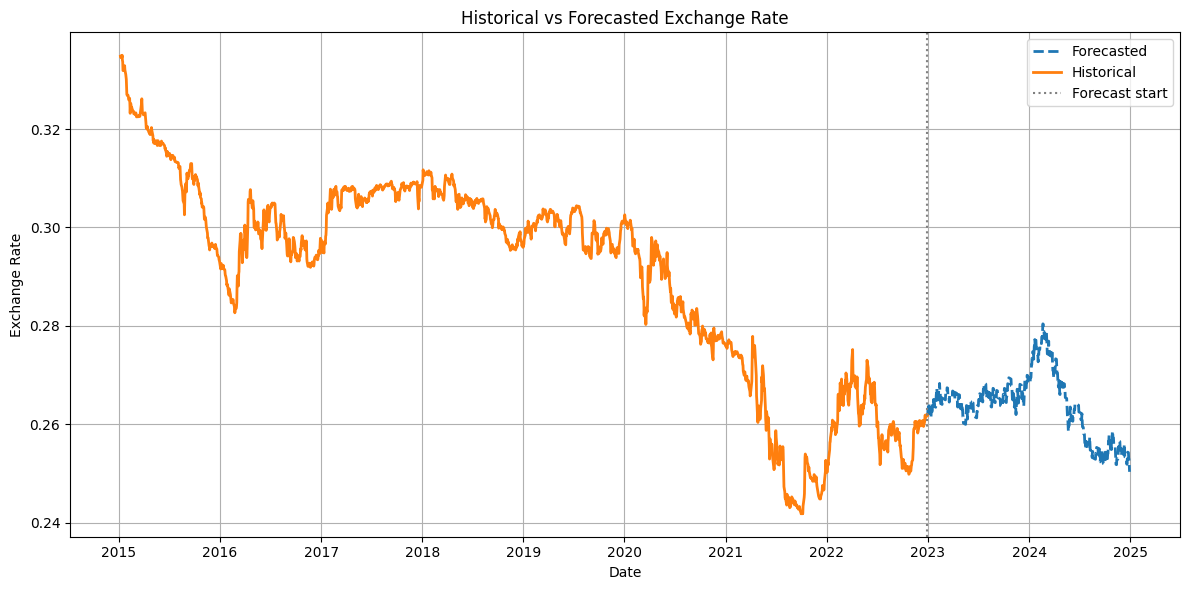

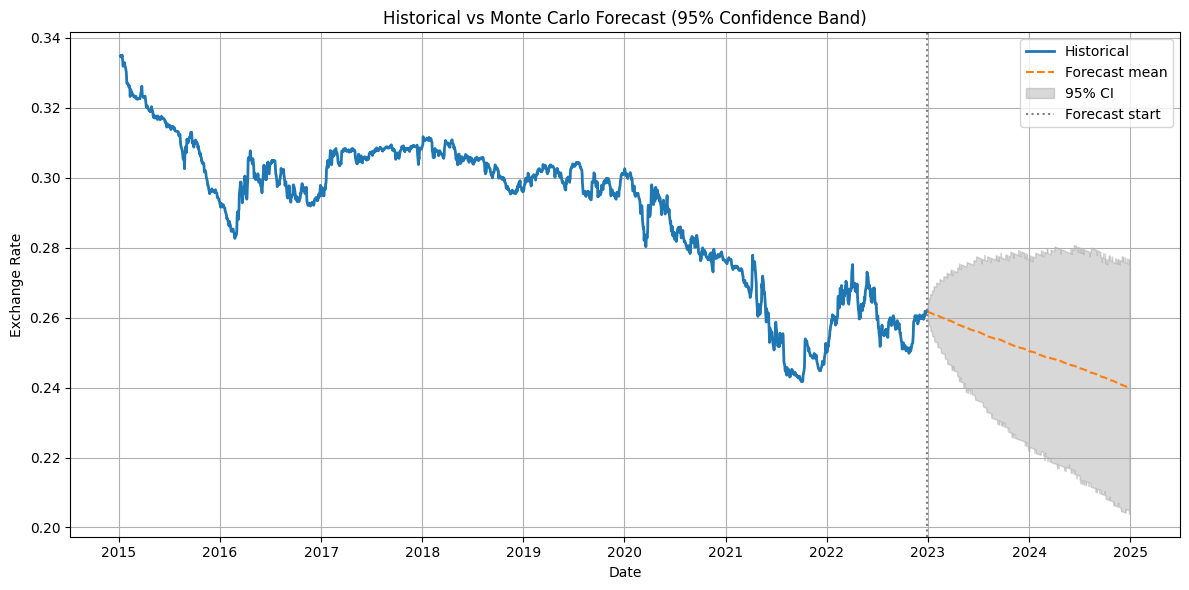

In [158]:
combined_df = plot_forecast_vs_history(train_df_dexuseu, df_forecast, rate_col='rate', rate_pred_col='rate_pred')
combined_df = plot_forecast_summary_vs_history(train_df_dexuseu, df_forecast_summary)


In [159]:
combined_df

,rate,source
date,,
2015-01-07,0.334784,Historical
2015-01-08,0.334560,Historical
2015-01-09,0.334896,Historical
2015-01-12,0.334560,Historical
2015-01-13,0.335008,Historical
...,...,...
2024-12-25,0.240037,Forecasted
2024-12-26,0.239995,Forecasted
2024-12-27,0.239969,Forecasted
